In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torch.nn import functional as F

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print ("cuda device not found.")


cuda device not found.


torch.Size([250, 250, 3])


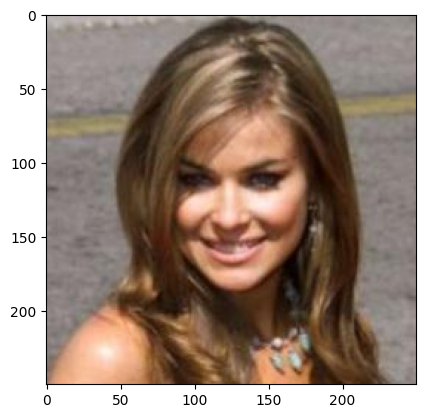

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**AutoEncoders** are neural networks used for unsupervised learning. They learn to compress (encode) the input into a lower-dimensional latent space and then reconstruct (decode) the input from this latent space. They are used for dimensionality reduction, denoising, and feature learning.

**VAEs**, on the other hand, are a probabilistic twist on autoencoders. They are used for generative tasks. VAEs don't just learn a compressed representation; they learn the parameters of a probability distribution representing the data. The encoder outputs means and variances which define a latent space distribution. New samples can be generated by sampling from this latent space and passing the sample through the decoder.

The key differences are:

**Applications:** Autoencoders are primarily used for feature learning and dimensionality reduction, while VAEs are generative models that can generate new data samples.

**Architecture:** In VAEs, the encoder outputs parameters of a distribution, unlike deterministic outputs in traditional autoencoders.

**Loss Function:** VAEs use a combination of reconstruction loss (like autoencoders) and a KL-divergence loss that forces the learned distribution to approximate a standard normal distribution.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim=(3, 250, 250), hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()


    def _build_encoder(self):
            return nn.Sequential(
            nn.Conv2d(in_channels=self.input_dim[0], out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8), self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dim, self.latent_dim * 2)  # Two times latent_dim for mean and variance
        )


    def _build_decoder(self):
            return nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dim, 128 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8)),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, self.input_dim[1] // 8, self.input_dim[2] // 8)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=self.input_dim[0], kernel_size=4, stride=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = torch.chunk(x, 2, dim=1)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.




In [10]:
model = VAE(input_dim=(3, 250, 250), hidden_dim=400, latent_dim=200)

for data in dataloader:
        img, y = data
        optimizer.zero_grad()

        mean, logvar = model.encode(img)
        print("mean shape:", mean.shape)
        print("logvar shape:", logvar.shape)

        output, mean, logvar = model(img)
        print("output shape:", output.shape)
        break

mean shape: torch.Size([32, 200])
logvar shape: torch.Size([32, 200])
output shape: torch.Size([32, 3, 250, 250])


Within the framework of our Variational Autoencoder (VAE), envision a magical apparatus comprised of two compartments—the encoder and the decoder. Picture the encoder as an intelligent camera; it not only captures an image but also comprehends it. When an image is fed into the encoder, it translates the image into a simplified representation known as the "latent space." This representation serves as a condensed form of knowledge, akin to a compressed file.

As we delve into the code, the encoder yields two essential components: the mean and the log variance. Analogously, consider the mean as the center of a paint blob on a palette, and the log variance as an indicator of the spread of that paint blob. Together, they define a cluster of points within our compressed image information.

The shapes denoted by mean.shape and log_var.shape reveal the dimensions of this representation. For instance, if the shape is [32, 200], it signifies 32 descriptions (matching our batch size) with each description comprising 200 values.

To generate novel samples, we employ a technique known as "reparameterization." Visualize reaching into the cloud of points with a magic wand, extracting a single point. This point, referred to as sampled_z, represents a new latent description with a unique twist. Mathematically, we introduce a touch of randomness to the mean based on the spread (variance).

This sampled point is then passed to the decoder, functioning like a reverse camera. The decoder reconstructs the compressed description into a full-fledged image. The verification lies in the comparison of reconstructed_img.shape with the original image dimensions, confirming the VAE's ability to transform a compressed description back into a complete image.

To generate entirely new samples—perhaps crafting a non-existent face—we simply need to extract additional points from the latent space and let the decoder perform its reconstruction magic. In essence, the VAE serves the dual purpose of compressing and generating images—an analogy to sketching a tree from a real tree and then cultivating a new tree from that sketch!

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


- create an optimizer for training


In [11]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [12]:
def vae_loss(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#Print the total number of parameters in the model
total_parameters = sum(m.numel() for m in model.parameters())
print("Total Parameters: ", total_parameters)

Total Parameters:  99101683


In [13]:
model = VAE()

In this scenario, the loss function used is a combination of two terms: the Binary Cross Entropy (BCE) loss and the Kullback-Leibler Divergence (KLD) loss. The overall loss is designed for training a Variational Autoencoder (VAE) model.

**Binary Cross Entropy (BCE) Loss:**

**Explanation:** BCE loss measures the dissimilarity between the reconstructed output (reconstructed_x) and the input data (x), assuming a binary distribution. It is well-suited for problems where each element of the input data can be treated independently, often used in binary classification tasks.
**Goal:** Minimizing the BCE loss encourages the VAE to generate reconstructions that closely match the original input data. This term promotes the fidelity of the reconstructed outputs.

**Kullback-Leibler Divergence (KLD) Loss:**

**Explanation:** KLD loss quantifies the difference between the learned distribution in the latent space (parameterized by mu and logvar) and a predetermined prior distribution. In the VAE context, the prior distribution is usually a standard Gaussian distribution.
**Goal:** By including the KLD term in the loss function, the model is encouraged to shape the latent space distribution to be close to the chosen prior. This regularization term helps in ensuring that the latent space has a meaningful structure, preventing overfitting, and aiding in the generation of diverse and meaningful samples during the decoding process.

**Overall Loss:**

**Explanation:** The total loss is the sum of the BCE and KLD terms, reflecting a trade-off between reconstruction accuracy (captured by BCE) and the regularization of the latent space (captured by KLD).
**Goal:** Minimizing the overall loss drives the VAE to learn a compact and structured latent representation while producing accurate reconstructions of the input data. The combination of BCE and KLD promotes a balanced learning process, where the model can both faithfully encode input information and generate novel samples.

In summary, the VAE loss function aims to strike a balance between accurately reconstructing input data and shaping a meaningful latent space distribution through the interplay of BCE and KLD terms.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [18]:
epochs = 10    # Number of epochs

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for data in dataloader:
        img, y = data
        optimizer.zero_grad()

        # Forward pass
        output, mean, logvar = model(img)

        # Calculate MSE loss
        mse_loss = F.mse_loss(output, img)

        # Calculate KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        # Total loss
        loss = mse_loss + kl_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print loss after each epoch
    print("\tEpoch ", epoch + 1, ", Average Loss: ", total_loss/len(dataloader.dataset))

Epoch 1, Average Loss: 1710.8442
Epoch 2, Average Loss: 1703.3759
Epoch 3, Average Loss: 1696.1160
Epoch 4, Average Loss: 1690.6316
Epoch 5, Average Loss: 1688.6123
Epoch 6, Average Loss: 1678.8141
Epoch 7, Average Loss: 1674.0226
Epoch 8, Average Loss: 1665.9473
Epoch 9, Average Loss: 1661.3201
Epoch 10, Average Loss: 1653.5139

If loss isn't decreasing:


*   Adjust the learning rate if the loss isn't decreasing. Experiment with
different rates to find an effective one.
*   Simplify the model if it's too complex, as overfitting may occur.
*   Ensure data quality with proper normalization and a representative dataset.
*   Experiment with different loss functions for better suitability to your task.
*   Review the code for bugs in model architecture, data loading, etc.
*   Monitor intermediate outputs by visualizing them during training to assess learning progress.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

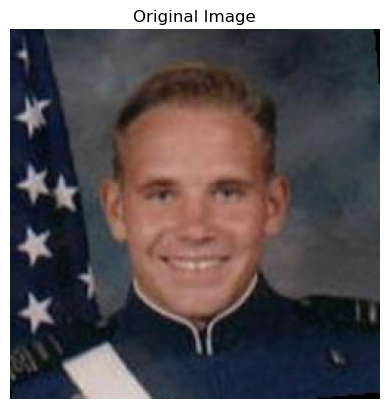

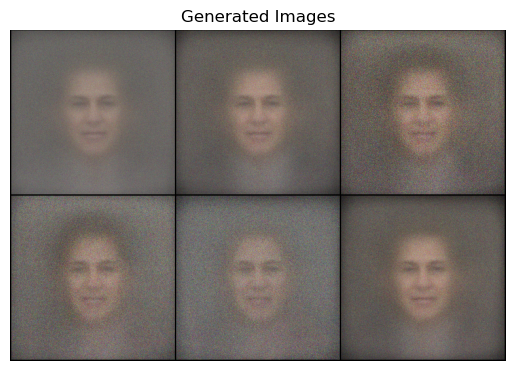

In [20]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid


model.eval()
def show_images(images, title):
    images = images.cpu().numpy()
    images = images.transpose((1, 2, 0))
    # Display the image
    plt.imshow(images)
    plt.title(title)
    plt.axis('off')


num_samples = 6
with torch.no_grad():
    z = torch.randn(num_samples, model.fc21.out_features)
    new_images = model.decode(z)

new_images = new_images.view(num_samples, 3, 250, 250)

data_iter = iter(dataloader)
original_image, _ = next(data_iter)
original_image = original_image[0]
show_images(original_image, 'Original Image')
plt.show()


generated_images_grid = make_grid(new_images, nrow=3)
show_images(generated_images_grid, 'Generated Images')
plt.show()
